## 04 - The Many Variables & The Spurious Waffles

#### Imports

In [1]:
# ruff: noqa: F405
from init_notebook import *
from causalgraphicalmodels import CausalGraphicalModel
import daft as daft

%config InlineBackend.figure_formats = ['svg']

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

import pymc as pm

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt

Watermark:
----------
Last updated: 2025-02-16T23:41:32.930892+04:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.32.0

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pandas    : 2.2.3
pymc      : 5.20.1
scipy     : 1.12.0
watermark : 2.5.0
arviz     : 0.20.0
matplotlib: 3.10.0
numpy     : 1.26.4



#### Introduction

One of the most reliable sources of waffles in North America, if not the entire world, is a Waffle House diner. Waffle House is nearly always open, even just after a hurricane. Most diners invest in disaster preparedness, including having their own electrical generators. As a consequence, the United States’ disaster relief agency (FEMA) informally uses Waffle House as an index of disaster severity. If the Waffle House is closed, that’s a serious event.

It is ironic then that steadfast Waffle House is associated with the nation’s highest divorce rates. States with many Waffle Houses per person, like Georgia and Alabama, also have some of the highest divorce rates in the United States. The lowest divorce rates are found where there are zero Waffle Houses. Could always-available waffles and hash brown potatoes put marriage at risk?

Probably not. This is an example of a misleading correlation. No one thinks there is any plausible mechanism by which Waffle House diners make divorce more likely. Instead, when we see a correlation of this kind, we immediately start asking about other variables that are really driving the relationship between waffles and divorce. In this case, Waffle House began in Georgia in the year 1955. Over time, the diners spread across the Southern United States, remaining largely within it. So Waffle House is associated with the South. Divorce is not a uniquely Southern institution, but the Southern United States has some of the highest divorce rates in the nation. So it’s probably just an accident of history that Waffle House and high divorce rates both occur in the South.

Such accidents are commonplace. It is not surprising that Waffle House is correlated with divorce, because correlation in general is not surprising. In large data sets, every pair of variables has a statistically discernible non-zero correlation. But since most correlations do not indicate causal relationships, we need tools for distinguishing mere association from evidence of causation. This is why so much effort is devoted to **multiple regression**, using more than one predictor variable to simultaneously model an outcome. Reasons given for multiple regression models include:

1) Statistical “control” for **confounds**. A confound is something that misleads us about a causal influence—there will be a more precise definition in the next chapter. The spurious waffles and divorce correlation is one type of confound, where southern-ness makes a variable with no real importance (Waffle House density) appear to be important. But confounds are diverse. They can hide important effects just as easily as they can produce false ones.
2) **Multiple and complex causation**. A phenomenon may arise from multiple simultaneous causes, and causes can cascade in complex ways. And since one cause can hide another, they must be measured simultaneously.
3) **Interactions**. The importance of one variable may depend upon another. For example, plants benefit from both light and water. But in the absence of either, the other is no benefit at all. Such interactions occur very often. Effective inference about one variable will often depend upon consideration of others.

In this chapter, we begin to deal with the first of these two, using multiple regression to deal with simple confounds and to take multiple measurements of association. You’ll see how to include any arbitrary number of *main effects* in your linear model of the Gaussian mean. These main effects are additive combinations of variables, the simplest type of multiple variable model. We’ll focus on two valuable things these models can help us with: (1) revealing *spurious* correlations like the Waffle House correlation with divorce and (2) revealing important correlations that may be masked by unrevealed correlations with other variables. Along the way, you’ll meet **categorical variables**, which require special handling compared to continuous variables.

However, multiple regression can be worse than useless, if we don’t know how to use it. Just adding variables to a model can do a lot of damage. In this chapter, we’ll begin to think formally about **causal inference** and introduce graphical causal models as a way to design and interpret regression models. The next chapter continues on this theme, describing some serious and common dangers of adding predictor variables, ending with a unifying framework for understanding the examples in both this chapter and the next.

**Causal inference**. Despite its central importance, there is no unified approach to causal inference yet in the sciences. There are even people who argue that cause does not really exist; it’s just a psychological illusion. And in complex dynamical systems, everything seems to cause everything else. “Cause” loses intuitive value. About one thing, however, there is general agreement: Causal inference always depends upon unverifiable assumptions. Another way to say this is that it’s always possible to imagine some way in which your inference about cause is mistaken, no matter how careful the design or analysis. A lot can be accomplished, despite this barrier.

#### Spurious Association

Let’s leave waffles behind, at least for the moment. An example that is easier to understand is the correlation between **divorce rate and marriage rate**. The rate at which adults marry is a great predictor of divorce rate, as seen in the plots below. But does marriage cause divorce? In a trivial sense it obviously does: One cannot get a divorce without first getting married. But there’s no reason high marriage rate must cause more divorce. It’s easy to imagine high marriage rate indicating high cultural valuation of marriage and therefore being associated with low divorce rate.

Another predictor associated with divorce is the **median age at marriage**, also displayed in a plot below. Age at marriage is also a good predictor of divorce rate — higher age at marriage predicts less divorce. But there is no reason this has to be causal, either, unless age at marriage is very late and the spouses do not live long enough to get a divorce.

Let’s load these data and standardize the variables of interest:

In [2]:
# load data
d = pd.read_csv("data/WaffleDivorce.csv", sep=';')

# standardize variables
d['D'] = utils.standardize(d.Divorce)
d['M'] = utils.standardize(d.Marriage)
d['A'] = utils.standardize(d.MedianAgeMarriage)

Median age of marriage and divorce rate linear regression model:

$$
\begin{align*}
  D_i &\sim \text{Normal}(\mu_i,\sigma) \\
  \mu_i &= \alpha + \beta_A A_{i} \\
  \alpha &\sim \text{Normal}(0, 0.2) \\
  \beta_A &\sim \text{Normal}(0,0.5) \\
  \sigma &\sim \text{Exponential}(1)
\end{align*}
$$

$D_i$ is the standardized (zero centered, standard deviation one) divorce rate for State $i$, and $A_i$ is State $i$’s standardized median age at marriage. 

What about those priors? Since the outcome and the predictor are both standardized, the intercept $α$ should end up very close to zero. What does the prior slope $β_A$ imply? If $β_A =1$, that would imply that a change of one standard deviation in age at marriage is associated likewise with a change of one standard deviation in divorce. To know whether or not that is a strong relationship, you need to know how big a standard deviation of age at marriage is:

In [3]:
d.MedianAgeMarriage.std()

1.2436303013880823

So when $β_A =1$, a change of 1.2 years in median age at marriage is associated with a full standard deviation change in the outcome variable. That seems like an insanely strong relationship. The prior above thinks that only 5% of plausible slopes are more extreme than 1. We’ll simulate from these priors in a moment, so you can see how they look in the outcome space.

To compute the approximate posterior, there are no new code tricks or techniques here. But I’ll add comments to help explain the mass of code to follow.

In [4]:
with pm.Model() as m5_1:
    A = pm.ConstantData("A", d.A, dims="obs_id")
    a = pm.Normal("a", mu=0, sigma=0.2)
    bA = pm.Normal("bA", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic('mu', a + bA * A, dims="obs_id")
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=d.D, dims="obs_id")

    # Prior predictive sample with -2 to 2 standardized median age marriage range
    pm.set_data({"A": np.linspace(-2,2)})
    idata_m5_1 = pm.sample_prior_predictive(var_names=['a', 'bA', 'sigma', 'mu', 'D'])    
    
    pm.set_data({"A": d.A})
    custom_step_m5_1 = utils.QuadraticApproximation([a, bA, sigma], m5_1)
    idata_m5_1.extend(pm.sample(draws=10_000, chains=1, tune=0, step=custom_step_m5_1, progressbar=False))
    
    # Posterior predictive sample with -3 to 3.2 standardized median age marriage range
    pm.set_data({"A": np.linspace(-3, 3.2, 30)})
    pm.sample_posterior_predictive(
        idata_m5_1,
        var_names=["D", "mu"],
        extend_inferencedata=True,
        progressbar=False
    )  

Sampling: [D, a, bA, sigma]
Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, bA, sigma]
Sampling 1 chain for 0 tune and 10_000 draw iterations (0 + 10_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [D]


To simulate from the priors, I have ran the PyMC function `pm.sample_prior_predictive`. I’ll plot the lines over the range of 2 standard deviations for both the outcome and predictor. That’ll cover most of the possible range of both variables.

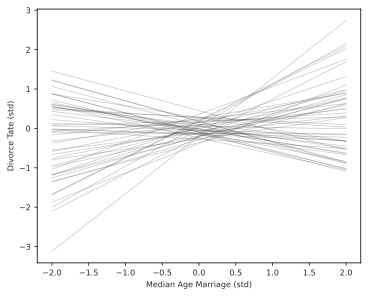

In [5]:
plt.plot(np.linspace(-2,2), az.extract(idata_m5_1, 'prior').mu[:,:50], 'k', alpha=0.2)
plt.xlabel('Median Age Marriage (std)')
plt.ylabel('Divorce Tate (std)');

Plausible regression lines implied by the priors in `m5_1`. These are weakly informative priors in that they allow some implusibly strong relationships but generally bound the lines to possible ranges of the variables.

You may wish to try some vaguer, flatter priors and see how quickly the prior regression lines become ridiculous.

Now for the posterior predictions. The procedure is exactly like earlier: compute `sample_posterior_predictive` and then summarize the $\mu$ with its mean of and HDI.

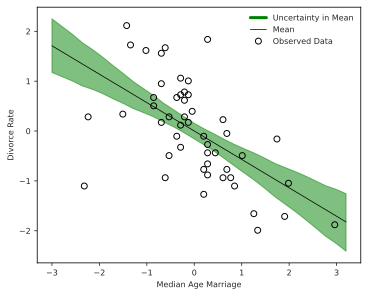

In [6]:
A_seq = np.linspace(-3, 3.2, 30)

fig, ax = plt.subplots()

hdi = az.plot_hdi(A_seq, idata_m5_1.posterior_predictive["mu"],
                  hdi_prob=0.89, smooth=False, color='green') 

mean_line, = ax.plot(A_seq, idata_m5_1.posterior_predictive["mu"].mean(dim=['chain', "draw"]), 'k', label='Mean')
obs_data, = ax.plot(d.A, d.D, 'o', fillstyle='none', label='Observed Data', color='k')

hdi_patch = plt.Line2D([0], [1], color='green', lw=3, label="Uncertainty in Mean")

ax.set(xlabel="Median Age Marriage",
       ylabel="Divorce Rate")

ax.legend(handles=[hdi_patch, mean_line, obs_data]);

In [7]:
az.summary(idata_m5_1, var_names=['~mu'], kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.000,0.098,-0.158,0.156
bA,-0.570,0.109,-0.738,-0.392
sigma,0.797,0.078,0.671,0.921


In [8]:
with pm.Model() as m5_2:
    M = pm.ConstantData("M", d.M, dims="obs_id")
    a = pm.Normal("a", mu=0, sigma=0.2)
    bM = pm.Normal("bM", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic('mu', a + bM * M, dims="obs_id")
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=d.D, dims="obs_id")

    idata_m5_2 = pm.sample_prior_predictive()    
    
    custom_step_m5_2 = utils.QuadraticApproximation([a, bM, sigma], m5_2)
    idata_m5_2.extend(pm.sample(draws=10_000, chains=1, tune=0, step=custom_step_m5_2, progressbar=False))
    
    pm.sample_posterior_predictive(
        idata_m5_2,
        var_names=["D", "mu"],
        extend_inferencedata=True,
        progressbar=False
    )  

Sampling: [D, a, bM, sigma]
Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, bM, sigma]
Sampling 1 chain for 0 tune and 10_000 draw iterations (0 + 10_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [D]


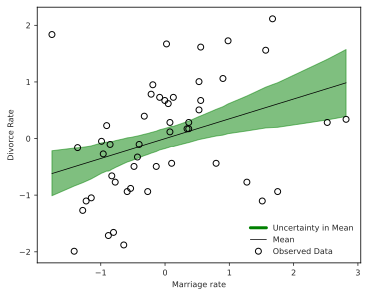

In [9]:
fig, ax = plt.subplots()

hdi = az.plot_hdi(d.M, idata_m5_2.posterior_predictive["mu"],
                  hdi_prob=0.89, smooth=False, color='green') 

mean_line, = ax.plot(d.M, idata_m5_2.posterior_predictive["mu"].mean(dim=['chain', "draw"]), 'k', label='Mean')
obs_data, = ax.plot(d.M, d.D, 'o', fillstyle='none', label='Observed Data', color='k')

hdi_patch = plt.Line2D([0], [1], color='green', lw=3, label="Uncertainty in Mean")

ax.set(xlabel="Marriage rate",
       ylabel="Divorce Rate")

ax.get_xticks()

ax.legend(handles=[hdi_patch, mean_line, obs_data]);

As you can see in the figure, this relationship isn’t as strong as the previous one.

Divorce rate is associated with both marriage rate and median age at marriage. Both predictor variables are standardized in this example. The average marriage rate across States is 20 per 1000 adults, and the average median age at marriage is 26 years.

But merely comparing parameter means between different bivariate regressions is no way to decide which predictor is better. Both of these predictors could provide independent value, or they could be redundant, or one could eliminate the value of the other.

To make sense of this, we’re going to have to think causally. And then, only after we’ve done some thinking, a bigger regression model that includes both age at marriage and marriage rate will help us.

##### Think Before you Regress

There are three observed variables in play: divorce rate (`D`), marriage rate (`M`), and the median age at marriage (`A`) in each State. The pattern we see in the previous two models and illustrated in the plots above is symptomatic of a situation in which only one of the predictor variables, `A` in this case, has a causal impact on the outcome, `D`, even though both predictor variables are strongly associated with the outcome.

To understand this better, it is helpful to introduce a particular type of causal graph known as a **DAG**, short for **directed acyclic graph**. *Graph* means it is nodes and connections. *Directed* means the connections have arrows that indicate directions of causal influence. And *acyclic* means that causes do not eventually flow back on themselves. A DAG is a way of describing qualitative causal relationships among variables. It isn’t as detailed as a full model description, but it contains information that a purely statistical model does not. Unlike a statistical model, a DAG will tell you the consequences of intervening to change a variable. But only if the DAG is correct. There is no inference without assumption.

The full framework for using DAGs to design and critique statistical models is complicated. So instead of smothering you in the whole framework right now, I’ll build it up one example at a time. By the end of the next chapter, you’ll have a set of simple rules that let you accomplish quite a lot of criticism. And then other applications will be introduced in later chapters.

Let’s start with the basics. Here is a possible DAG for our divorce rate example:

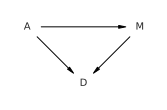

In [10]:
dag5_1 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")])
pgm1 = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm1.add_node(node, node, *coordinates[node], plot_params={'linewidth': 0})
for edge in dag5_1.dag.edges:
    pgm1.add_edge(*edge)
pgm1.render()
plt.gca().invert_yaxis()

It may not look like much, but this type of diagram does a lot of work. It represents a heuristic causal model. Like other models, it is an analytical assumption. The symbols $A$, $M$, and $D$ are our **observed variables**. The arrows show directions of influence. What this DAG says is:
1) A directly influences D
2) M directly influences D
3) A directly influences M

These statements can then have further implications. In this case, age of marriage influences divorce in two ways. First it has a direct effect, A → D. Perhaps a direct effect would arise because younger people change faster than older people and are therefore more likely to grow incompatible with a partner. Second, it has an indirect effect by influencing the marriage rate, which then influences divorce, A → M → D. If people get married earlier, then the marriage rate may rise, because there are more young people. Consider for example if an evil dictator forced everyone to marry at age 65. Since a smaller fraction of the population lives to 65 than to 25, forcing delayed marriage will also reduce the marriage rate. If marriage rate itself has any direct effect on divorce, maybe by making marriage more or less normative, then some of that direct effect could be the indirect effect of age at marriage.

To infer the strength of these different arrows, we need more than one statistical model. Model `m5_1`, the regression of D on A, tells us only that the total influence of age at marriage is strongly negative with divorce rate. The “total” here means we have to account for every path from A to D. There are two such paths in this graph: A → D, a direct path, and A → M → D, an indirect path. In general, it is possible that a variable like A has no direct effect at all on an outcome like D. It could still be associated with D entirely through the indirect path. That type of relationship is known as **mediation**, and we’ll have another example later. 

As you’ll see however, the indirect path does almost no work in this case. How can we show that? We know from `m5_2` that marriage rate is positively associated with divorce rate. But that isn’t enough to tell us that the path M → D is positive. It could be that the association between M and D arises entirely from A’s influence on both M and D. Like this:

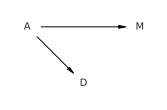

In [11]:
dag5_2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
pgm2 = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_2.dag.nodes:
    pgm2.add_node(node, node, *coordinates[node], plot_params={'linewidth': 0})
for edge in dag5_2.dag.edges:
    pgm2.add_edge(*edge)
pgm2.render()
plt.gca().invert_yaxis()

This DAG is also consistent with the posterior distributions of models `m5_1` and `m5_2`. Why? Because both $M$ and $D$ “listen” to $A$. They have information from $A$. So when you inspect the association between $D$ and $M$, you pick up that common information that they both got from listening to $A$. You’ll see a more formal way to deduce this, in the later.

So which is it? Is there a direct effect of marriage rate, or rather is age at marriage just driving both, creating a spurious correlation between marriage rate and divorce rate? To find out, we need to consider carefully what each DAG implies.

**What’s a cause?** Questions of causation can become bogged down in philosophical debates. These debates are worth having. But they don’t usually intersect with statistical concerns. Knowing a cause in statistics means being able to correctly predict the consequences of an intervention. There are contexts in which even this is complicated. For example, it isn’t possible to directly change someone’s body weight. Changing someone’s body weight would mean intervening on another variable, like diet, and that variable would have other causal effects in addition. But being underweight can still be a legitimate cause of disease, even when we can’t intervene on it directly.

##### Testable Implications

How do we use data to compare multiple, plausible causal models? The first thing to consider is the **testable implications** of each model. Consider the two DAGs we have so far considered:

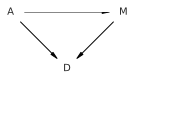

In [12]:
pgm1.render()
plt.gca().invert_yaxis()

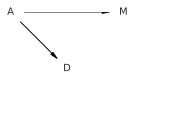

In [13]:
pgm2.render()
plt.gca().invert_yaxis()

Any DAG may imply that some variables are independent of others under certain conditions. These are the model’s testable implications, its conditional independencies. Conditional independencies come in two forms. First, they are statements of which variables should be associated with one another (or not) in the data. Second, they are statements of which variables become dis-associated when we condition on some other set of variables.

What does “conditioning” mean? Informally, conditioning on a variable Z means learning its value and then asking if X adds any additional information about Y. If learning X doesn’t give you any more information about Y, then we might say that Y is independent of X conditional on Z. This conditioning statement is sometimes written as: $Y \perp\!\!\!\perp X \mid Z$. This is very weird notation and any feelings of annoyance on your part are justified. We’ll work with this concept a lot, so don’t worry if it doesn’t entirely make sense right now. You’ll see examples very soon.

Let’s consider conditional independence in the context of the divorce example. What are the conditional independencies of the DAGs at the top? How do we derive these conditional independencies? Finding conditional independencies is not hard, but also not at all obvious. With a little practice, it becomes very easy. The more general rules can wait until later. For now, let’s consider each DAG in turn and inspect the possibilities.

For the DAG on the left above, the one with three arrows, first note that every pair of variables is correlated. This is because there is a causal arrow between every pair. These arrows create correlations. So before we condition on anything, everything is associated with everything else. This is already a testable implication. We could write it:

$$D \not\!\perp\!\!\!\perp A \qquad D \not\!\perp\!\!\!\perp M \qquad A \not\!\perp\!\!\!\perp M$$

That $\not\!\perp\!\!\!\perp$ thing means "not independent of". If we now look in the data and find that any pair of variables are not associated, then something is wrong with the DAG (assuming the data are correct). In these data, all three pairs are in fact strongly associated. Check for yourself. You can use `cor` to measure simple correlations. Correlations are sometimes terrible measures of association — many different patterns of association with different implications can produce the same correlation. But they do honest work in this case.

Are there any other testable implications for the first DAG above? No. It will be easier to see why, if we slide over to consider the second DAG, the one in which $M$ has no influence on $D$. In this DAG, it is still true that all three variables are associated with one another. $A$ is associated with $D$ and $M$ because it influences them both. And $D$ and $M$ are associated with one another, because $M$ influences them both. They share a cause, and this leads them to be correlated with one another through that cause. But suppose we condition on $A$. All of the information in M that is relevant to predicting $D$ is in $A$. So once we’ve conditioned on $A$, $M$ tells us nothing more about $D$. So in the second DAG, a testable implication is that $D$ is independent of $M$, conditional on $A$. In other words, $D \perp\!\!\!\perp M \mid A$. The same thing does not happen with the first DAG. Conditioning on $A$ does not make $D$ independent of $M$, because $M$ really influences $D$ all by itself in this model. 

Later, we’ll see the general rules for deducing these implications. For now, the `daft` & `CausalGraphicalModel` packages have the rules built in and can find the implications for you. Here’s the code to define the second DAG and display the implied conditional independencies.

In [14]:
print('DAG 1:', dag5_1.get_distribution())
print('DAG 2:', dag5_2.get_distribution())

# get_all_independence_relationships() method 
# Returns a list of all pairwise conditional independence relationships 
# implied by the graph structure.
dag5_2.get_all_independence_relationships()

# [('M', 'D', {'A'})] means D _||_ M | A

DAG 1: P(A)P(M|A)P(D|A,M)
DAG 2: P(A)P(D|A)P(M|A)


[('M', 'D', {'A'})]

The first DAG has no conditional independencies.

In [15]:
dag5_1.get_all_independence_relationships()

[]

There are no conditional independencies, so there is no output to display.

Let’s try to summarize. The testable implications of the first DAG are that all pairs of variables should be associated, whatever we condition on. The testable implications of the second DAG are that all pairs of variables should be associated, before conditioning on anything, but that D and M should be independent after conditioning on A. So the only implication that differs between these DAGs is the last one: $D \perp\!\!\!\perp M \mid A$.

To test this implication, we need a statistical model that conditions on A, so we can see whether that renders D independent of M. And that is what multiple regression helps with. It can address a useful *descriptive* question:

> Is there any additional value in knowing a variable, once I already know all of the other predictor variables?

So for example once you fit a multiple regression to predict divorce using both marriage rate and age at marriage, the model addresses the questions:
1) After I already know marriage rate, what additional value is there in also knowing age at marriage?
2) After I already know age at marriage, what additional value is there in also knowing marriage rate?

The parameter estimates corresponding to each predictor are the (often opaque) answers to these questions. The questions above are descriptive, and the answers are also descriptive. It is only the derivation of the testable implications above that gives these descriptive results a causal meaning. But that meaning is still dependent upon believing the DAG.

**“Control” is out of control**. Very often, the question just above is spoken of as “statistical control,” as in controlling for the effect of one variable while estimating the effect of another. But this is sloppy language, as it implies too much. Statistical control is quite different from experimental control, as we’ll explore more in the later. The point here isn’t to police language. Instead, the point is to observe the distinction between small world and large world interpretations. Since most people who use statistics are not statisticians, sloppy language like “control” can promote a sloppy culture of interpretation. Such cultures tend to overestimate the power of statistical methods, so resisting them can be difficult. Disciplining your own language may be enough. Disciplining another’s language is hard to do, without seeming like a fastidious scold, as this very box must seem.

##### Multiple Regression Notation

Multiple regression formulas look a lot like the polynomial models, they add more parameters and variables to the definition of $μ_i$. The strategy is straightforward:
1) Nominate the predictor variables you want in the linear model of the mean.
2) For each predictor, make a parameter that will measure its conditional association with the outcome.
3) Multiply the parameter by the variable and add that term to the linear model.

Here is the model that predicts divorce rate, using both marriage rate and age at marriage.

$$\begin{align*}
D_{i} &\sim \text{Normal}(\mu, \sigma)\tag{Probability of Data}\\
\mu_i &\sim \alpha + \beta_M M_i + \beta_A A_i\tag{Linear Model} \\
\alpha &\sim \text{Normal}(0,0.2)\tag{α Prior} \\
\beta_M &\sim \text{Normal}(0,0.5)\tag{β Prior} \\
\beta_A &\sim \text{Normal}(0,0.5)\tag{β Prior} \\
\sigma &\sim \text{Exponential}(1)\tag{σ Prior} \\
\end{align*}$$


You can use whatever symbols you like for the parameters and variables, but here I’ve chosen R for marriage rate and A for age at marriage, reusing these symbols as subscripts for the corresponding parameters. But feel free to use whichever symbols reduce the load on your own memory.

So what does it mean to assume $\mu_i \sim \alpha + \beta_M M_i + \beta_A A_i$? Mechanically, it means that the expected outcome for any State with marriage rate $M_i$ and median age at marriage $A_i$ is the sum of three independent terms. If you are like most people, this is still pretty mysterious. The mechanical meaning of the equation doesn’t map onto a unique causal meaning. Let’s take care of the mechanical bits first, before returning to interpretation.

**Compact notation and the design matrix**. Often, linear models are written using a compact form like:

$$\mu_i = \alpha + \sum_{j=1}^{n} \beta_j x_{ji}$$

where $j$ is an index over predictor variables and $n$ is the number of predictor variables. This may be read as the **mean is modeled as the sum of an intercept and an additive combination of the products of parameters and predictors**. Even more compactly, using matrix notation:
$$\boldsymbol{m} = \boldsymbol{Xb}$$
where **m** is a vector of predicted means, one for each row in the data, $\boldsymbol{b}$ is a (column) vector of parameters, one for each predictor variable (including the intercept), and $\boldsymbol{X}$ is a matrix. This matrix is called a **design matrix**. It has as many rows as the data, and as many columns as there are predictors plus one. So $\boldsymbol{X}$ is basically a data frame, but with an extra first column. The extra column is filled with 1s. These 1s are multiplied by the first parameter, which is the intercept, and so return the unmodified intercept. When $\boldsymbol{X}$ is matrix-multiplied by $\boldsymbol{b}$, you get the predicted means. In Python notation, this operation is `X @ b`.

We’re not going to use the design matrix approach. But it’s good to recognize it, and sometimes it can save you a lot of work. For example, for linear regressions, there is a nice matrix formula for the maximum likelihood (or least squares) estimates. Most statistical software exploits that formula.

##### Approximating the Posterior

To fit this model to the divorce data, we just expand the linear model. Here’s the model definition again:

$$
\begin{align*}
D_{i} &\sim \text{Normal}(\mu, \sigma)\\
\mu_i &\sim \alpha + \beta_M M_i + \beta_A A_i\\
\alpha &\sim \text{Normal}(0,0.2) \\
\beta_M &\sim \text{Normal}(0,0.5)\\
\beta_A &\sim \text{Normal}(0,0.5)\\
\sigma &\sim \text{Exponential}(1)\\
\end{align*}
$$

And here is the code to approximate the posterior distribution:

In [16]:
with pm.Model() as m5_3:
    M = pm.ConstantData("M", d.M, dims="obs_id")
    A = pm.ConstantData("A", d.A, dims="obs_id")
    
    a = pm.Normal("a", mu=0, sigma=0.2)
    bA = pm.Normal("bA", mu=0, sigma=0.5)
    bM = pm.Normal("bM", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    
    mu = pm.Deterministic('mu', a + (bM * M) + (bA * A), dims="obs_id")
    
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=d.D, dims="obs_id")  
    idata_m5_3 = pm.sample_prior_predictive(var_names=['a', 'bA', 'bM', 'sigma', 'mu', 'D'])   
    
    custom_step_m5_3 = utils.QuadraticApproximation([a, bM, bA, sigma], m5_3)
    idata_m5_3.extend(pm.sample(draws=10_000, chains=1, tune=0, step=custom_step_m5_3, progressbar=False))
    
    pm.sample_posterior_predictive(
        idata_m5_3,
        var_names=["D", "mu"],
        extend_inferencedata=True,
        progressbar=False
    )  

Sampling: [D, a, bA, bM, sigma]
Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, bM, bA, sigma]
Sampling 1 chain for 0 tune and 10_000 draw iterations (0 + 10_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [D]


In [17]:
az.summary(idata_m5_3.posterior, var_names=['~mu'], kind='stats', hdi_prob=0.89).round(2)

,mean,sd,hdi_5.5%,hdi_94.5%
a,-0.00,0.10,-0.16,0.15
bA,-0.61,0.15,-0.86,-0.38
bM,-0.06,0.15,-0.30,0.18
sigma,0.79,0.08,0.67,0.92


The posterior mean for marriage rate, `bM`, is now close to zero, with plenty of probability of both sides of zero. The posterior mean for age at marriage, `bA`, is essentially unchanged. It will help to visualize the posterior distributions for all three models, focusing just on the slope parameters $β_A$ and $β_M$:

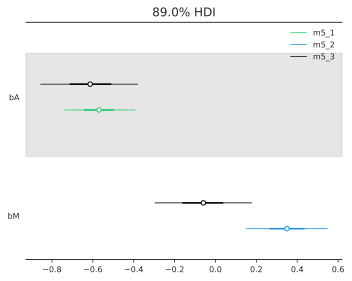

In [18]:
fig, ax = plt.subplots()

az.plot_forest(
    [
        idata_m5_3,
        idata_m5_2,
        idata_m5_1,
    ],
    model_names=["m5_3", "m5_2", "m5_1"],
    hdi_prob=0.89,
    var_names=["bA", "bM"],
    combined=True,
    ax=ax
)

fig.tight_layout()

The posterior means are shown by the points and the 89% compatibility intervals by the solid horizontal lines. Notice how `bA` doesn’t move, only grows a bit more uncertain, while `bM` is only associated with divorce when age at marriage is missing from the model. You can interpret these distributions as saying:

> Once we know median age at marriage for a State, there is little or no additional predictive power in also knowing the rate of marriage in that State.

In that weird notation, $D \perp\!\!\!\perp M \mid A$. This tests the implication of the second DAG from earlier. Since the first DAG did not imply this result, it is out.

Note that this does not mean that there is no value in knowing marriage rate. Consistent with the earlier DAG, if you didn’t have access to age-at-marriage data, then you’d definitely find value in knowing the marriage rate. $M$ is predictive but not causal. Assuming there are no other causal variables missing from the model (more on that later), this implies there is no important direct causal path from marriage rate to divorce rate. The association between marriage rate and divorce rate is spurious, caused by the influence of age of marriage on both marriage rate and divorce rate. I’ll leave it to the reader to investigate the relationship between age at marriage, $A$, and marriage rate, M, to complete the picture. 

But how did model `m5_3` achieve the inference that marriage rate adds no additional information, once we know age at marriage? Let’s draw some pictures.

**Simulating the divorce example**. The divorce data are real data. But it is useful to simulate the kind of causal relationships shown in the previous DAG: $M ← A → D$. Every DAG implies a simulation, and such simulations can help us design models to correctly infer relationships among variables. In this case, you just need to simulate each of the three variables:

In [19]:
N = 50
age = stats.norm().rvs(N)       # sim A
mar = stats.norm(-age).rvs(N)   # sim A -> M
div = stats.norm(age).rvs(N)    # sim A -> D

Now if you use these variables in models `m5_1`, `m5_2`, and `m5_3`, you’ll see the same pattern of posterior inferences. It is also possible to simulate that both $A$ and $M$ influence $D$: `div = stats.norm(age + mar).rvs(N)`. In that case, a naive regression of $D$ on $A$ will overestimate the influence of $A$, just like a naive regression of $D$ on $M$ will overestimate the importance of $M$. The multiple regression will help sort things out for you in this situation as well. But interpreting the parameter estimates will always depend upon what you believe about the causal model, because typically several (or very many) causal models are consistent with any one set of parameter estimates. We’ll discuss this later as **Markov equivalence**.

##### Plotting Multivariate Posteriors

There are a lot of moving parts here: three variables, some strange DAGs, and three models. If you feel at all confused, it is only because you are paying attention. 

It will help to visualize the model’s inferences. Visualizing the posterior distribution in simple bivariate regressions, like those in the earlier, is easy. There’s only one predictor variable, so a single scatterplot can convey a lot of information. And so earlier we used scatters of the data. Then we overlaid regression lines and intervals to both (1) visualize the size of the association between the predictor and outcome and (2) to get a crude sense of the ability of the model to predict the individual observations. With multivariate regression, you’ll need more plots. There is a huge literature detailing a variety of plotting techniques that all attempt to help one understand multiple linear regression. None of these techniques is suitable for all jobs, and most do not generalize beyond linear regression. So the approach I take here is to instead help you compute whatever you need from the model. I offer three examples of interpretive plots:

1) **Predictor residual plots**. These plots show the outcome against residual predictor values. They are useful for understanding the statistical model, but not much else.
2) **Posterior prediction plots**. These show model-based predictions against raw data, or otherwise display the error in prediction. They are tools for checking fit and assessing predictions. They are not causal tools.
3) **Counterfactual plots**. These show the implied predictions for imaginary experiments. These plots allow you to explore the causal implications of manipulating one or more variables.

Each of these plot types has its advantages and deficiencies, depending upon the context and the question of interest. In the rest of this section, I show you how to manufacture each of these in the context of the divorce data.

##### Predictor Residual Plots

A predictor residual is the average prediction error when we use all of the other predictor variables to model a predictor of interest. That’s a complicated concept, so we’ll go straight to the example, where it will make sense. The benefit of computing these things is that, once plotted against the outcome, we have a bivariate regression that has already conditioned on all of the other predictor variables. It leaves the variation that is not expected by the model of the mean, $μ$, as a function of the other predictors.

In our model of divorce rate, we have two predictors: (1) marriage rate $M$ and (2) median age at marriage $A$. To compute predictor residuals for either, we just use the other predictor to model it. So for marriage rate, this is the model we need:

$$
\begin{align*}
M_{i} &\sim \text{Normal}(\mu, \sigma)\\
\mu_i &\sim \alpha + \beta A_i\\
\alpha &\sim \text{Normal}(0,0.2) \\
\beta &\sim \text{Normal}(0,0.5)\\
\sigma &\sim \text{Exponential}(1)\\
\end{align*}
$$

As before, $M$ is marriage rate and A is median age at marriage. Note that since we standardized both variables, we already expect the mean αto be around zero, as before. So I’m reusing the same priors as earlier. This code will approximate the posterior:

In [20]:
with pm.Model() as m5_4:
    A = pm.ConstantData("A", d.A, dims="obs_id")
    
    a = pm.Normal("a", mu=0, sigma=0.2)
    bAM = pm.Normal("bAM", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic('mu', a + bAM * A, dims="obs_id")
    
    M = pm.Normal("M", mu=mu, sigma=sigma, observed=d.M, dims="obs_id")

    idata_m5_4 = pm.sample_prior_predictive()    
    
    custom_step_m5_4 = utils.QuadraticApproximation([a, bAM, sigma], m5_4)
    idata_m5_4.extend(pm.sample(draws=10_000, chains=1, tune=0, step=custom_step_m5_4, progressbar=False))
    
    pm.sample_posterior_predictive(
        idata_m5_4,
        var_names=["M", "mu"],
        extend_inferencedata=True,
        progressbar=False
    )  

Sampling: [M, a, bAM, sigma]
Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, bAM, sigma]
Sampling 1 chain for 0 tune and 10_000 draw iterations (0 + 10_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [M]


And then we compute the residuals by subtracting the observed marriage rate in each State from the predicted rate, based upon the model above:

In [21]:
mu_mean_m5_4 = idata_m5_4.posterior.mu.mean(dim=['chain', 'draw']).to_numpy()
mu_residual_m5_4 = d.M - mu_mean_m5_4

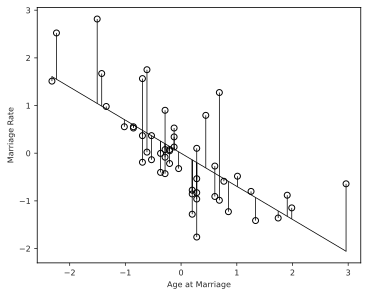

In [22]:
from matplotlib import collections

_, ax = plt.subplots()
ax.plot(d.A, d.M, 'o', fillstyle='none')
ax.plot(d.A, mu_mean_m5_4, 'k')

segments = [[(d.A[i], d.M[i]), (d.A[i], mu_mean_m5_4[i])] for i in range(len(d.M))]
lc = collections.LineCollection(segments)
ax.add_collection(lc)
ax.set(xlabel='Age at Marriage', ylabel='Marriage Rate');

When a residual is positive, that means that the observed rate was in excess of what the model expects, given the median age at marriage in that State. When a residual is negative, that means the observed rate was below what the model expects. In simpler terms, States with positive residuals have high marriage rates for their median age of marriage, while States with negative residuals have low rates for their median age of marriage. It’ll help to plot the relationship between these two variables, and show the residuals as well. In the plot above, we show `m5_4` along with line segments for each residual. Notice that the residuals are variation in marriage rate that is left over, after taking out the purely linear relationship between the two variables.



Now to use these residuals, let’s put them on a horizontal axis and plot them against the actual outcome of interest, divorce rate. In the plot below, we plot these residuals against divorce rate, overlaying the linear regression of the two variables. You can think of this plot as displaying the linear relationship between divorce and marriage rates, having conditioned already on median age of marriage. The vertical dashed line indicates marriage rate that exactly matches the expectation from median age at marriage. So States to the right of the line have higher marriage rates than expected. States to the left of the line have lower rates. Average divorce rate on both sides of the line is about the same, and so the regression line demonstrates little relationship between divorce and marriage rates.

Sampling: [D, a, bM, sigma]
Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, bM, sigma]
Sampling 1 chain for 0 tune and 10_000 draw iterations (0 + 10_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [D]


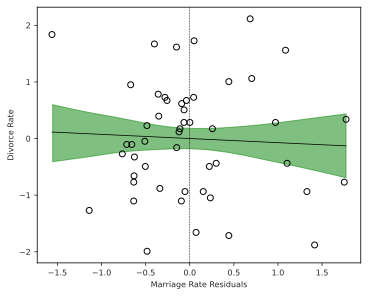

In [23]:
with pm.Model() as m5_residual1:
    M = pm.ConstantData("M", mu_residual_m5_4, dims="obs_id")
    
    a = pm.Normal("a", mu=0, sigma=0.2)
    bM = pm.Normal("bM", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic('mu', a + bM * M, dims="obs_id")
    
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=d.D, dims="obs_id")

    idata_m5_residual1 = pm.sample_prior_predictive()    
    
    custom_step_m5_residual1 = utils.QuadraticApproximation([a, bM, sigma], m5_residual1)
    idata_m5_residual1.extend(pm.sample(draws=10_000, chains=1, tune=0, step=custom_step_m5_residual1, progressbar=False))
    
    pm.sample_posterior_predictive(
        idata_m5_residual1,
        var_names=["D", "mu"],
        extend_inferencedata=True,
        progressbar=False
    )  

_, ax = plt.subplots()

hdi = az.plot_hdi(mu_residual_m5_4, idata_m5_residual1.posterior_predictive["mu"],
                  hdi_prob=0.89, smooth=True, color='green', ax=ax) 

ax.plot(mu_residual_m5_4, idata_m5_residual1.posterior_predictive.mu.mean(dim=['chain', 'draw']), 'k')
ax.plot(mu_residual_m5_4, d.D, 'o', fillstyle='none')
ax.axvline(0, linestyle='--', linewidth=0.5)

ax.set(xlabel='Marriage Rate Residuals', ylabel='Divorce Rate');

In [24]:
with pm.Model() as m5_4a:
    M = pm.ConstantData("M", d.M, dims="obs_id")
    
    a = pm.Normal("a", mu=0, sigma=0.2)
    bMA = pm.Normal("bAM", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic('mu', a + bMA * M, dims="obs_id")
    
    A = pm.Normal("A", mu=mu, sigma=sigma, observed=d.A, dims="obs_id")

    idata_m5_4a = pm.sample_prior_predictive()    
    
    custom_step_m5_4a = utils.QuadraticApproximation([a, bMA, sigma], m5_4a)
    idata_m5_4a.extend(pm.sample(draws=10_000, chains=1, tune=0, step=custom_step_m5_4a, progressbar=False))
    
    pm.sample_posterior_predictive(
        idata_m5_4a,
        var_names=["M", "mu"],
        extend_inferencedata=True,
        progressbar=False
    )  

Sampling: [A, a, bAM, sigma]
Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, bAM, sigma]
Sampling 1 chain for 0 tune and 10_000 draw iterations (0 + 10_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: []


In [25]:
mu_mean_m5_4a = idata_m5_4a.posterior.mu.mean(dim=['chain', 'draw']).to_numpy()
mu_residual_m5_4a = d.A - mu_mean_m5_4a

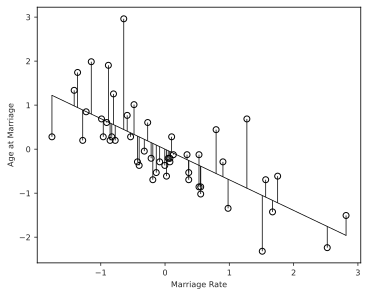

In [26]:
_, ax = plt.subplots()
ax.plot(d.M, d.A, 'o', fillstyle='none')
ax.plot(d.M, mu_mean_m5_4a, 'k')

segments = [[(d.M[i], d.A[i]), (d.M[i], mu_mean_m5_4a[i])] for i in range(len(d.A))]
lc = collections.LineCollection(segments)
ax.add_collection(lc)
ax.set(xlabel='Marriage Rate', ylabel='Age at Marriage');

The same procedure works for the other predictor. The plot above shows the regression of $A$ on $M$ and the residuals. In the plot below, these residuals are used to predict divorce rate. States to the right of the vertical dashed line have older-than-expected median age at marriage, while those to the left have younger-than-expected median age at marriage. Now we find that the average divorce rate on the right is lower than the rate on the left, as indicated by the regression line. States in which people marry older than expected for a given rate of marriage tend to have less divorce.

Sampling: [D, a, bA, sigma]
Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, bA, sigma]
Sampling 1 chain for 0 tune and 10_000 draw iterations (0 + 10_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [D]


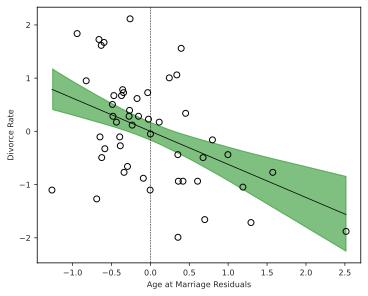

In [27]:
with pm.Model() as m5_residual2:
    A = pm.ConstantData("A", mu_residual_m5_4a, dims="obs_id")
    
    a = pm.Normal("a", mu=0, sigma=0.2)
    bA = pm.Normal("bA", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic('mu', a + bA * A, dims="obs_id")
    
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=d.D, dims="obs_id")
    
    idata_m5_residual2 = pm.sample_prior_predictive()    
    
    custom_step_m5_residual2 = utils.QuadraticApproximation([a, bA, sigma], m5_residual2)
    idata_m5_residual2.extend(pm.sample(draws=10_000, chains=1, tune=0, step=custom_step_m5_residual2, progressbar=False))
    
    pm.sample_posterior_predictive(
        idata_m5_residual2,
        var_names=["D", "mu"],
        extend_inferencedata=True,
        progressbar=False
    )

_, ax = plt.subplots()

hdi = az.plot_hdi(mu_residual_m5_4a, idata_m5_residual2.posterior_predictive["mu"],
                  hdi_prob=0.89, smooth=True, color='green', ax=ax) 

ax.plot(mu_residual_m5_4a, idata_m5_residual2.posterior_predictive.mu.mean(dim=['chain', 'draw']), 'k')
ax.plot(mu_residual_m5_4a, d.D, 'o', fillstyle='none')
ax.axvline(0, linestyle='--', linewidth=0.5)

ax.set(xlabel='Age at Marriage Residuals', ylabel='Divorce Rate');

So what’s the point of all of this? There’s conceptual value in seeing the model-based predictions displayed against the *outcome, after subtracting out the influence of other predictors*. The plots in in this section do this. But this procedure also brings home the message that **regression models measure the remaining association of each predictor with the outcome, after already knowing the other predictors**. In computing the predictor residual plots, you had to perform those calculations yourself. In the unified multivariate model, it all happens automatically. Nevertheless, it is useful to keep this fact in mind, because regressions can behave in surprising ways as a result. We’ll have an example soon.

Linear regression models do all of this simultaneous measurement with a very specific *additive model* of how the variables relate to one another. But predictor variables can be related to one another in non-additive ways. The basic logic of statistical conditioning does not change in those cases, but the details definitely do, and these residual plots cease to be useful. Luckily there are other ways to understand a model. That’s where we turn next.

**Residuals are parameters, not data**. There is a tradition, especially in parts of biology, of using residuals from one model as data in another model. For example, a biologist might regress brain size on body size and then use the brain size residuals as data in another model. This procedure is always a mistake. Residuals are not known. They are parameters, variables with unobserved values. Treating them as known values throws away uncertainty. The right way to adjust for body size is to include it in the same model, preferably a model designed in light of an explicit causal model.

##### Posterior Prediction Plots

It’s important to check the model’s implied predictions against the observed data. This is what we did earlier, when we simulated globe tosses, averaging over the posterior, and comparing the simulated results to the observed. These kinds of checks are useful in many ways. For now, we’ll focus on two uses.

1) Did the model correctly approximate the posterior distribution? Errors can be more easily diagnosed by comparing implied predictions to the raw data. Some caution is required, because not all models try to exactly match the sample. But even then, you’ll know what to expect from a successful approximation. You’ll see some examples later.
2) How does the model fail? Models are useful fictions. So they always fail in some way. Sometimes, a model fits correctly but is still so poor for our purposes that it must be discarded. More often, a model predicts well in some respects, but not in others. By inspecting the individual cases where the model makes poor predictions, you might get an idea of how to improve it. The difficulty is that this process is essentially creative and relies upon the analyst’s domain expertise. No robot can (yet) do it for you. It also risks chasing noise, a topic we’ll focus on in later chapters.

How could we produce a simple **posterior predictive check** in the divorce example? Let’s begin by simulating predictions, averaging over the posterior.

In [ ]:
mu_mean = idata_m5_3.posterior_predictive.mu.mean(dim=['chain', 'draw'])
mu_pi = az.hdi(idata_m5_3.posterior_predictive.mu, hdi_prob=0.89)

# D_sim = az.extract(idata_m5_3.posterior_predictive, 'posterior_predictive', var_names='D', num_samples=int(1e4))
D_sim = idata_m5_3.posterior_predictive.D.mean(dim=['chain', 'draw'])
D_pi = az.hdi(idata_m5_3.posterior_predictive.D, hdi_prob=0.89)

For multivariate models, there are many different ways to display these simulations. The simplest is to just plot predictions against observed. This code will do that, and then add a line to show perfect prediction and line segments for the confidence interval of each prediction: